<a href="https://colab.research.google.com/github/Angelicogfa/analise_fraude/blob/master/03-modelagem_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem do dataset transacional

Transformação do dataset transacional em um dataset agrupado com objetivo de analisar as transações dentro de uma janela de tempo

## Biblitecas

Bibliotecas utilizadas para o processo

In [1]:
%pip install openai -q -U

In [2]:
import os
import math
import json
import shutil
import openai
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carregamento de dados e ajuste de dados/valores

In [4]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str
7475327,2010-01-01 00:01:00,1556,2972,-77.0,"""Swipe Transaction""",59935,"""Beulah""","""ND""",58523.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",30,67,1989,7,"""Female""","""594 Mountain View Street""",46.8,-100.76,23679.0,48277.0,110153.0,740,4,"""Mastercard""","""Debit (Prepaid)""",5497590243197280,"""07/2022""",306,"""YES""",2,55.0,"""05/2008""",2008,"""No"""
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""","""No""",48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""","""No""",49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…","""No""",51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""","""No""",47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No"""


In [5]:
df_time = df.to_pandas()
df_time['target'].value_counts()

,count
target,
No,8901631
Yes,13332


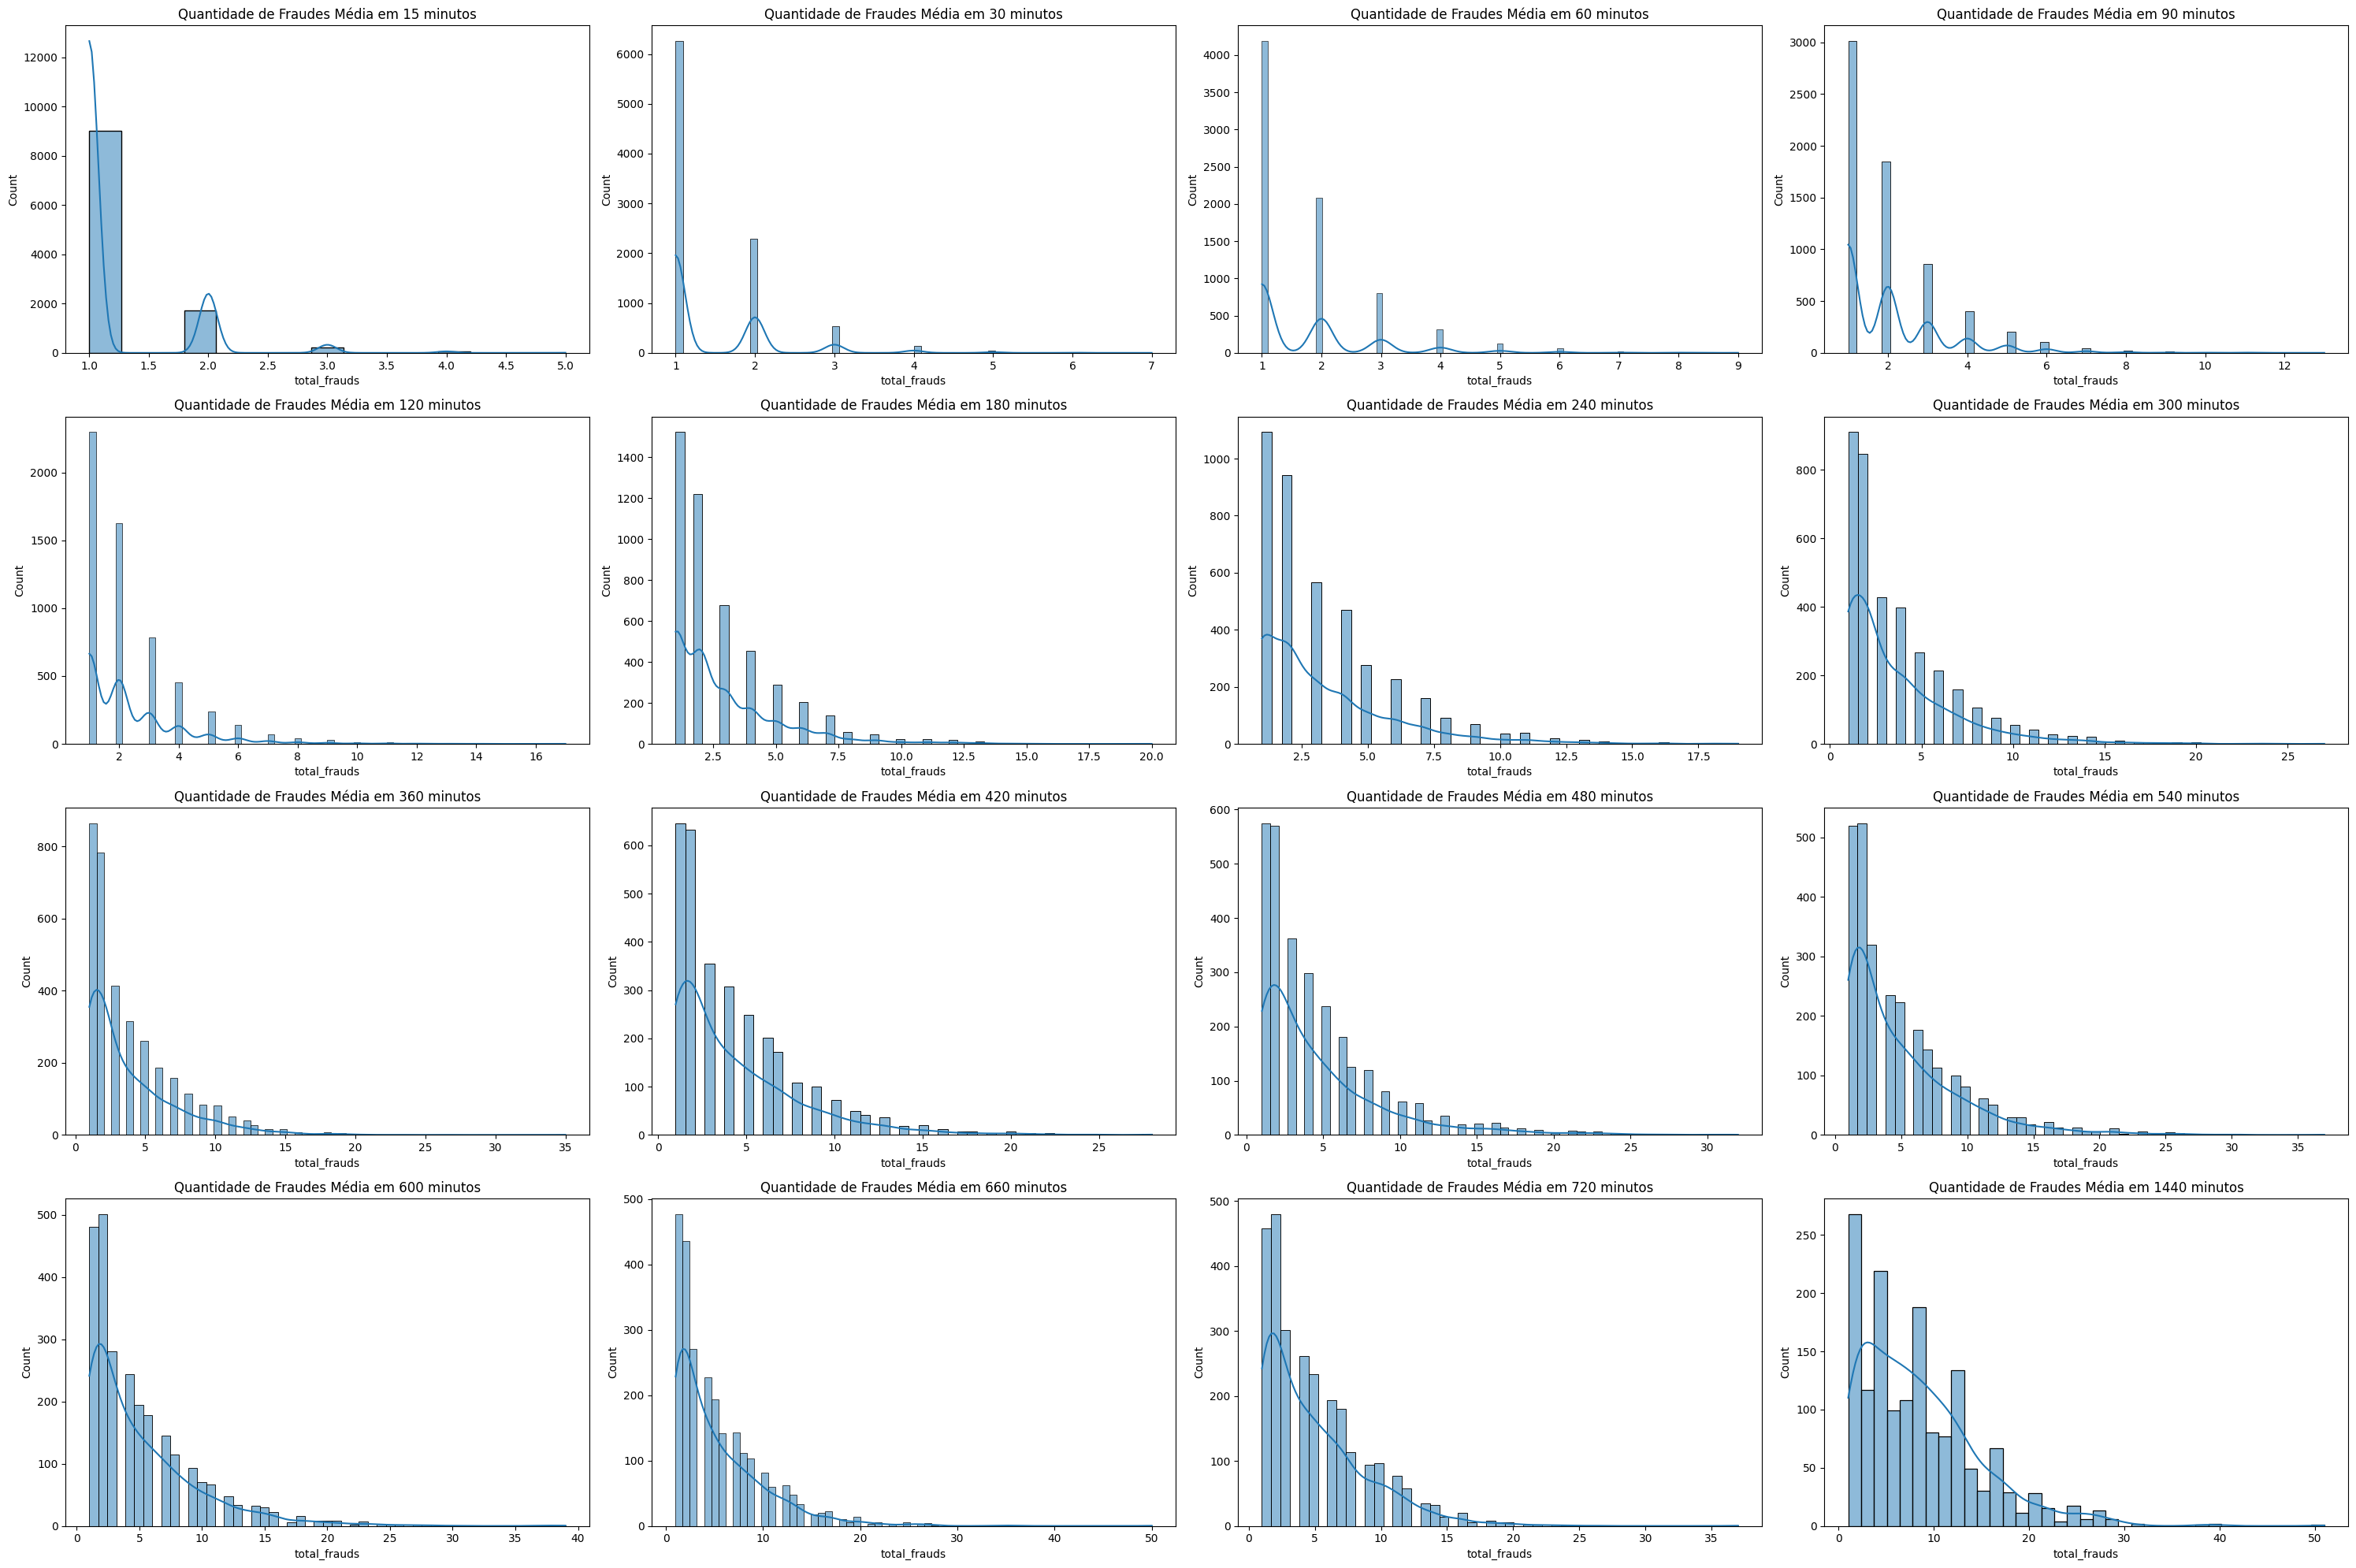

In [6]:
minutes = [15, 30, 60, 90, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 1440]
df_time = df.to_pandas()

# Define número de colunas
cols = 4
# Calcula número de linhas necessárias
rows = math.ceil(len(minutes) / cols)

plt.figure(figsize=(30, 5 * rows))  # Ajuste proporcional ao número de linhas

for i, minute in enumerate(minutes):
    plt.subplot(rows, cols, i + 1)
    plt.title(f'Quantidade de Fraudes Média em {minute} minutos')

    df_minutes = pd.DataFrame()
    df_minutes['slide_date'] = df_time['date'].dt.floor(f'{minute}T')
    df_minutes['target'] = df_time['target'].apply(lambda x: 1 if x == 'Yes' else 0)

    df_minutes = df_minutes.groupby(by='slide_date').agg({'target': 'sum'}).reset_index()
    df_minutes.columns = ['slide_date', 'total_frauds']

    sns.histplot(df_minutes.query('total_frauds > 0')['total_frauds'], kde=True)

plt.tight_layout()
plt.show()

In [7]:
df = df.filter(pl.col('amount') >= pl.lit(0))

In [8]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
).with_columns(
    pl.when(pl.col('has_chip').str.to_lowercase() == 'yes')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('card_has_chip')
).drop('merchant_state', 'merchant_city', 'has_chip')
df.sample(5)

id,date,client_id,card_id,amount,use_chip,merchant_id,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country,card_has_chip
i64,datetime[ns],i64,i64,f64,str,i64,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,i64,f64,str,i64,str,str,str,str,str
11345795,2012-07-03 16:51:00,1141,5224,1.61,"""Swipe Transaction""",14528,27101.0,"""5499""","""Technical Glitch""","""Miscellaneous Food Stores""","""No""",66,57,1953,10,"""Male""","""35 Essex Drive""",36.48,-80.61,15838.0,27266.0,19798.0,777,5,"""Visa""","""Debit""",4094653186833148,"""06/2023""",298,2,20161.0,"""10/2010""",2010,"""No""","""No""","""Winston Salem""","""United States""","""Yes"""
13944721,2014-02-01 18:30:00,545,1120,1.43,"""Swipe Transaction""",14528,61611.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",55,67,1964,10,"""Male""","""22 First Boulevard""",40.67,-89.54,22416.0,45707.0,113194.0,715,3,"""Mastercard""","""Debit""",5500745251339739,"""12/2021""",290,2,7898.0,"""02/2007""",2014,"""No""","""No""","""East Peoria""","""United States""","""Yes"""
9239160,2011-03-06 13:35:00,1980,5829,175.04,"""Swipe Transaction""",74934,94606.0,"""3596""",null,"""Miscellaneous Machinery and Pa…","""No""",54,63,1965,5,"""Male""","""990 West Street""",29.37,-95.45,22856.0,46603.0,57177.0,612,1,"""Mastercard""","""Debit""",5950930953873248,"""11/2023""",808,2,12224.0,"""12/2005""",2006,"""No""","""No""","""Oakland""","""United States""","""Yes"""
18113639,2016-07-21 06:09:00,614,4002,22.33,"""Chip Transaction""",59935,28025.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",84,66,1935,9,"""Female""","""129 Sussex Street""",35.4,-80.59,20570.0,16430.0,2873.0,779,7,"""Mastercard""","""Debit""",5953826141797560,"""07/2024""",781,1,19508.0,"""07/2012""",2012,"""No""","""No""","""Concord""","""United States""","""Yes"""
9689608,2011-06-19 17:58:00,1313,4183,66.36,"""Swipe Transaction""",81833,15084.0,"""5912""",null,"""Drug Stores and Pharmacies""","""No""",35,67,1985,1,"""Male""","""9853 Sussex Street""",40.61,-79.83,14798.0,30172.0,39959.0,653,2,"""Mastercard""","""Debit (Prepaid)""",5983193668955521,"""05/2021""",265,2,87.0,"""08/2006""",2016,"""No""","""No""","""Tarentum""","""United States""","""Yes"""


In [9]:
colunas_numericas = [
    col for col in df.columns if df[col].dtype in pl.NUMERIC_DTYPES
]
df.select(colunas_numericas).describe()

statistic,id,client_id,card_id,amount,merchant_id,zip,current_age,retirement_age,birth_year,birth_month,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_number,cvv,num_cards_issued,credit_limit,year_pin_last_changed
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",8.472184e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6,7.376549e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6,8.472184e6
"""null_count""",0.0,0.0,0.0,0.0,0.0,1.095635e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.5589e7,1026.994373,3478.726505,50.544429,47652.713839,51168.936355,54.078883,66.493463,1965.10336,6.566359,37.368174,-91.513651,23956.057796,46618.34378,57801.138872,714.120904,3.848335,4.8189e15,495.150668,1.520839,15531.411964,2011.344943
"""std""",4.7031e6,580.753627,1676.115333,73.849862,26197.552799,29396.872652,15.749063,3.577259,15.737973,3.607138,5.090949,16.262071,11874.003957,24239.056146,51961.813415,65.71816,1.570767,1.3082e15,288.574908,0.51528,12186.276023,2.892089
"""min""",7.475328e6,0.0,0.0,0.0,1.0,1001.0,23.0,53.0,1918.0,1.0,21.3,-158.18,0.0,1.0,0.0,488.0,1.0,3.0011e14,0.0,1.0,0.0,2002.0
"""25%""",1.1513568e7,520.0,2418.0,11.04,25187.0,28379.0,42.0,65.0,1956.0,3.0,33.89,-97.34,17140.0,32817.0,16437.0,684.0,3.0,4.4899e15,247.0,1.0,8052.0,2010.0
"""50%""",1.5576543e7,1072.0,3590.0,31.88,45122.0,47519.0,52.0,66.0,1967.0,7.0,38.35,-86.44,21159.0,41069.0,51633.0,716.0,4.0,5.1118e15,498.0,2.0,13461.0,2011.0
"""75%""",1.9656812e7,1529.0,4930.0,66.31,69952.0,77587.0,63.0,68.0,1977.0,10.0,41.12,-80.08,27376.0,54122.0,84949.0,756.0,5.0,5.5683e15,741.0,2.0,20827.0,2013.0
"""max""",2.376187e7,1998.0,6138.0,6613.44,100342.0,99928.0,101.0,79.0,1996.0,12.0,48.53,-68.67,163145.0,280199.0,461854.0,850.0,9.0,6.9942e15,999.0,3.0,141391.0,2020.0


## Conversão do dataset em um dataset agrupado

Utilizando uma janela de tempo de 360 min para agrupar os dados.

Features aplicadas para os tipos de dados:

> Totais

Utilização do total de transações existentes no grupo e quantidade de fraudes existentes nesse grupo.

> Variaveis Numéricas

Padronização dos dados em escalas

* amount / 1000
* per_capita_income / 1000
* yearly_income / 1000
* total_debt / 1000
* credit_score / 100
* credit_limit / 1000


Utilização das estatisticas abaixo para obter o comportamento desses dados para o grupo:

* Mínimo: Valor mínimo da feature dentro da janela de agrupamento
* Média: Valor médio da feature dentro da janela de agrupamento
* Máximo: Valor máximo da feature dentro da janela de agrupamento

> Variáveis Categoricas

* Razão proporcional da feature em relação ao alvo, agrupada por clusters e convertida em variáveis dummies por janela de registros

Razão -> Cluster -> Dummies -> Proporção

> Variáveis Binárias

* Identificação de fraude na janela atual com base na janela anterior

In [10]:
df = df.with_columns((pl.col('amount') / pl.lit(1_000)).alias('amount')) \
  .with_columns((pl.col('per_capita_income') / pl.lit(1_000)).alias('per_capita_income')) \
  .with_columns((pl.col('yearly_income') / pl.lit(1_000)).alias('yearly_income')) \
  .with_columns((pl.col('total_debt') / pl.lit(1_000)).alias('total_debt')) \
  .with_columns((pl.col('credit_score') / pl.lit(100)).alias('credit_score')) \
  .with_columns((pl.col('credit_limit') / pl.lit(1_000)).alias('credit_limit'))

In [11]:
df = df.with_columns(
    pl.col('date').dt.truncate('360m').alias('date_window')
)

In [12]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

### Agrupamento de dados numéricos com base em estatisticas

In [13]:
def generate_columns_statistics(column_name: str) -> list:
    return [
        pl.col(column_name).min().alias(f'min_{column_name}'),
        pl.col(column_name).mean().alias(f'median_{column_name}'),
        pl.col(column_name).max().alias(f'max_{column_name}'),
    ]

In [14]:
aggregate = [pl.col('amount').count().alias('transactions'), pl.col('target').sum().alias('frauds'), pl.col('amount').sum().alias('total_amount')]
for column in ['amount', 'current_age', 'per_capita_income', 'total_debt', 'credit_score', 'num_credit_cards', 'credit_limit']:
  aggregate.extend(generate_columns_statistics(column))

In [15]:
df_model = df.group_by('date_window').agg(
    *aggregate
).sort('date_window')
df_model.head()

date_window,transactions,frauds,total_amount,min_amount,median_amount,max_amount,min_current_age,median_current_age,max_current_age,min_per_capita_income,median_per_capita_income,max_per_capita_income,min_total_debt,median_total_debt,max_total_debt,min_credit_score,median_credit_score,max_credit_score,min_num_credit_cards,median_num_credit_cards,max_num_credit_cards,min_credit_limit,median_credit_limit,max_credit_limit
datetime[ns],u32,i32,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64
2010-01-01 00:00:00,132,0,5.23025,0.00018,0.039623,0.27022,30,54.628788,101,0.0,22.462932,55.362,0.0,58.221811,211.919,4.91,7.162273,8.5,1,3.94697,8,0.03,16.065136,76.343
2010-01-01 06:00:00,813,0,28.73916,0.00021,0.03535,1.15361,28,55.579336,101,0.0,24.074888,137.428,0.0,56.695812,461.854,4.91,7.16075,8.5,1,3.97909,9,0.0,15.062614,70.187
2010-01-01 12:00:00,766,0,40.78623,0.0,0.053246,1.30971,28,56.356397,99,0.0,24.24873,163.145,0.0,54.322728,461.854,4.91,7.16154,8.5,1,3.881201,9,0.0,15.741868,125.723
2010-01-01 18:00:00,480,1,24.99157,0.00011,0.052066,0.6923,30,55.416667,98,0.0,24.630685,137.428,0.0,53.964465,242.379,4.88,7.082521,8.5,1,3.83125,8,0.0,14.942865,96.637
2010-01-02 00:00:00,111,0,8.57293,0.00017,0.077234,0.84396,32,55.333333,90,10.091,22.90418,53.676,0.0,57.401495,206.0,4.91,7.155315,8.5,1,3.900901,8,0.031,14.475153,57.294


### Agrupamento de dados categoricos em categorias dummies

In [16]:
def create_cluster_target_fields(df: pl.DataFrame, group_column_name: str, target_column_name: str, n_clusters: int = 3, drop_first=False) -> pl.DataFrame:

  PERCENT_TARGET_COLUMN = f'percent_{target_column_name}'
  PERCENT_NO_TARGET_COLUMN = f'percent_no_{target_column_name}'
  AB_COLUMN = 'ab'
  TARGET_CLUSTER_COLUMN = f'{target_column_name}_{group_column_name}'

  df_cat_group = df.group_by(group_column_name).agg([
      ((pl.col(target_column_name).sum() / pl.count()) * 100).alias(PERCENT_TARGET_COLUMN),
      (((pl.count() - pl.col(target_column_name).sum())/pl.count())*100).alias(PERCENT_NO_TARGET_COLUMN)
  ]).with_columns((pl.col(PERCENT_TARGET_COLUMN)/pl.col(PERCENT_NO_TARGET_COLUMN)).alias(AB_COLUMN)) \
    .with_columns(pl.when(pl.col(AB_COLUMN).is_infinite()).then(pl.lit(100)).otherwise(pl.col(AB_COLUMN)).alias(AB_COLUMN)) \
    .with_columns(pl.when(pl.col(AB_COLUMN) > pl.lit(100)).then(pl.lit(100)).otherwise(pl.col(AB_COLUMN)).alias(AB_COLUMN))

  min_max = MinMaxScaler()
  kmeans = KMeans(n_clusters=n_clusters)
  cluster_index = kmeans.fit_predict(min_max.fit_transform(df_cat_group[[AB_COLUMN]]))
  df_cat_group = df_cat_group.with_columns(pl.lit(cluster_index).alias(TARGET_CLUSTER_COLUMN))

  return df_cat_group.select([group_column_name, TARGET_CLUSTER_COLUMN]).to_dummies(columns=[TARGET_CLUSTER_COLUMN], drop_first=drop_first)


In [17]:
for column in ['city', 'country', 'description']:
  df_target_cat = create_cluster_target_fields(df, column, 'target', drop_first=False)
  df_with_cat = df.select(['date_window', column]).join(df_target_cat, on=column, how='left').drop(column)
  df_with_cat = df_with_cat.group_by('date_window').sum()
  df_with_cat = df_with_cat.with_columns(
      (pl.sum_horizontal([pl.col(col) for col in df_with_cat.columns[1:]])).alias('total')
  )
  df_with_cat = df_with_cat.with_columns(
      [(pl.col(col) / pl.col('total')).alias(col) for col in df_with_cat.drop('total').columns[1:]]
  ).drop('total')
  df_model = df_model.join(df_with_cat, on='date_window', how='left')
df_model.head(10)

date_window,transactions,frauds,total_amount,min_amount,median_amount,max_amount,min_current_age,median_current_age,max_current_age,min_per_capita_income,median_per_capita_income,max_per_capita_income,min_total_debt,median_total_debt,max_total_debt,min_credit_score,median_credit_score,max_credit_score,min_num_credit_cards,median_num_credit_cards,max_num_credit_cards,min_credit_limit,median_credit_limit,max_credit_limit,target_city_0,target_city_1,target_city_2,target_country_0,target_country_1,target_country_2,target_description_0,target_description_1,target_description_2
datetime[ns],u32,i32,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,132,0,5.23025,0.00018,0.039623,0.27022,30,54.628788,101,0.0,22.462932,55.362,0.0,58.221811,211.919,4.91,7.162273,8.5,1,3.94697,8,0.03,16.065136,76.343,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-01 06:00:00,813,0,28.73916,0.00021,0.03535,1.15361,28,55.579336,101,0.0,24.074888,137.428,0.0,56.695812,461.854,4.91,7.16075,8.5,1,3.97909,9,0.0,15.062614,70.187,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-01 12:00:00,766,0,40.78623,0.0,0.053246,1.30971,28,56.356397,99,0.0,24.24873,163.145,0.0,54.322728,461.854,4.91,7.16154,8.5,1,3.881201,9,0.0,15.741868,125.723,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-01 18:00:00,480,1,24.99157,0.00011,0.052066,0.6923,30,55.416667,98,0.0,24.630685,137.428,0.0,53.964465,242.379,4.88,7.082521,8.5,1,3.83125,8,0.0,14.942865,96.637,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-02 00:00:00,111,0,8.57293,0.00017,0.077234,0.84396,32,55.333333,90,10.091,22.90418,53.676,0.0,57.401495,206.0,4.91,7.155315,8.5,1,3.900901,8,0.031,14.475153,57.294,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-02 06:00:00,679,0,34.10798,0.0002,0.050233,1.41114,29,55.393225,101,0.0,24.209027,163.145,0.0,55.601508,461.854,4.89,7.095729,8.5,1,3.918999,8,0.0,15.222744,141.391,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-02 12:00:00,730,0,37.15319,0.00012,0.050895,0.433,29,55.616438,99,0.0,24.413727,163.145,0.0,55.359051,461.854,4.89,7.166082,8.5,1,3.909589,9,0.0,15.059014,125.723,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-02 18:00:00,369,0,20.35572,0.0,0.055165,0.83729,28,54.284553,99,0.0,22.062108,76.725,0.0,55.236241,252.106,4.88,7.056883,8.5,1,3.95393,8,0.0,14.885263,96.637,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2010-01-03 00:00:00,116,0,6.58992,0.00043,0.05681,0.43672,28,54.974138,90,0.0,23.238664,58.517,0.0,60.799819,211.919,5.27,7.181379,8.5,1,4.060345,8,0.0,15.231552,47.833,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Variáveis Binárias - Inclusão de variaveis binárias com base em dados existentes

In [18]:
df_model = df_model.with_columns(
    pl.when(pl.col('frauds') > pl.lit(0))
      .then(pl.lit(1))
      .otherwise(pl.lit(0))
      .shift(n=1)
      .alias('previous_frauds')
      .fill_null(0)
)

## Normalização

In [29]:
df_model.describe()

statistic,date_window,transactions,frauds,median_amount,max_amount,min_current_age,median_current_age,max_current_age,min_per_capita_income,median_per_capita_income,max_per_capita_income,min_total_debt,median_total_debt,max_total_debt,min_credit_score,median_credit_score,max_credit_score,min_num_credit_cards,median_num_credit_cards,max_num_credit_cards,median_credit_limit,max_credit_limit,target_city_0,target_city_1,target_description_0,target_description_2,previous_frauds
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""14363""",14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2014-12-01 10:40:50.797187""",589.861728,0.894103,0.054108,0.866673,25.68022,53.933532,98.307596,1.711871,23.78235,118.297238,0.017645,57.825287,356.932003,4.951486,7.144627,8.494954,1.000766,3.85602,8.501845,15.473542,101.98088,0.99996,0.000004,0.999948,0.000019,0.233726
"""std""",null,332.905259,2.285803,0.016098,0.430993,1.984802,1.100665,3.179176,3.752219,0.697543,39.237448,0.993831,2.851801,107.63795,0.149014,0.04068,0.035339,0.038231,0.093005,0.520349,0.667395,33.732296,0.000504,0.000126,0.000383,0.000188,0.423214
"""min""","""2010-01-01 00:00:00""",1.0,0.0,0.030616,0.10213,23.0,26.0,26.0,0.0,9.71,9.71,0.0,0.686,0.686,4.88,6.82,6.82,1.0,2.0,2.0,0.974,0.974,0.971963,0.0,0.990741,0.0,0.0
"""25%""","""2012-06-17 00:00:00""",177.0,0.0,0.04841,0.52393,24.0,53.290076,98.0,0.0,23.440535,94.302,0.0,56.02256,242.379,4.89,7.119318,8.5,1.0,3.803828,8.0,15.110939,70.187,1.0,0.0,1.0,0.0,0.0
"""50%""","""2014-12-01 12:00:00""",566.0,0.0,0.054424,0.81813,25.0,53.992647,99.0,0.0,23.869233,137.428,0.0,57.796768,328.089,4.91,7.142803,8.5,1.0,3.850178,9.0,15.491194,98.1,1.0,0.0,1.0,0.0,0.0
"""75%""","""2017-05-17 06:00:00""",895.0,0.0,0.059522,1.09448,27.0,54.612591,101.0,0.0,24.226301,163.145,0.0,59.5372,461.854,4.91,7.166538,8.5,1.0,3.9,9.0,15.855859,137.669,1.0,0.0,1.0,0.0,0.0
"""max""","""2019-10-31 18:00:00""",1122.0,35.0,1.15331,6.61344,55.0,68.666667,101.0,30.307,37.597,163.145,80.367,102.569,461.854,7.88,7.88,8.5,4.0,5.222222,9.0,29.927,141.391,1.0,0.008696,1.0,0.007299,1.0


In [32]:
df_model = df_model.with_columns((pl.col('transactions') / pl.lit(100)).alias('transactions')).drop('max_total_debt')

### Analise de correlação

Análise de correlação nos dados após criação do dataset agregado

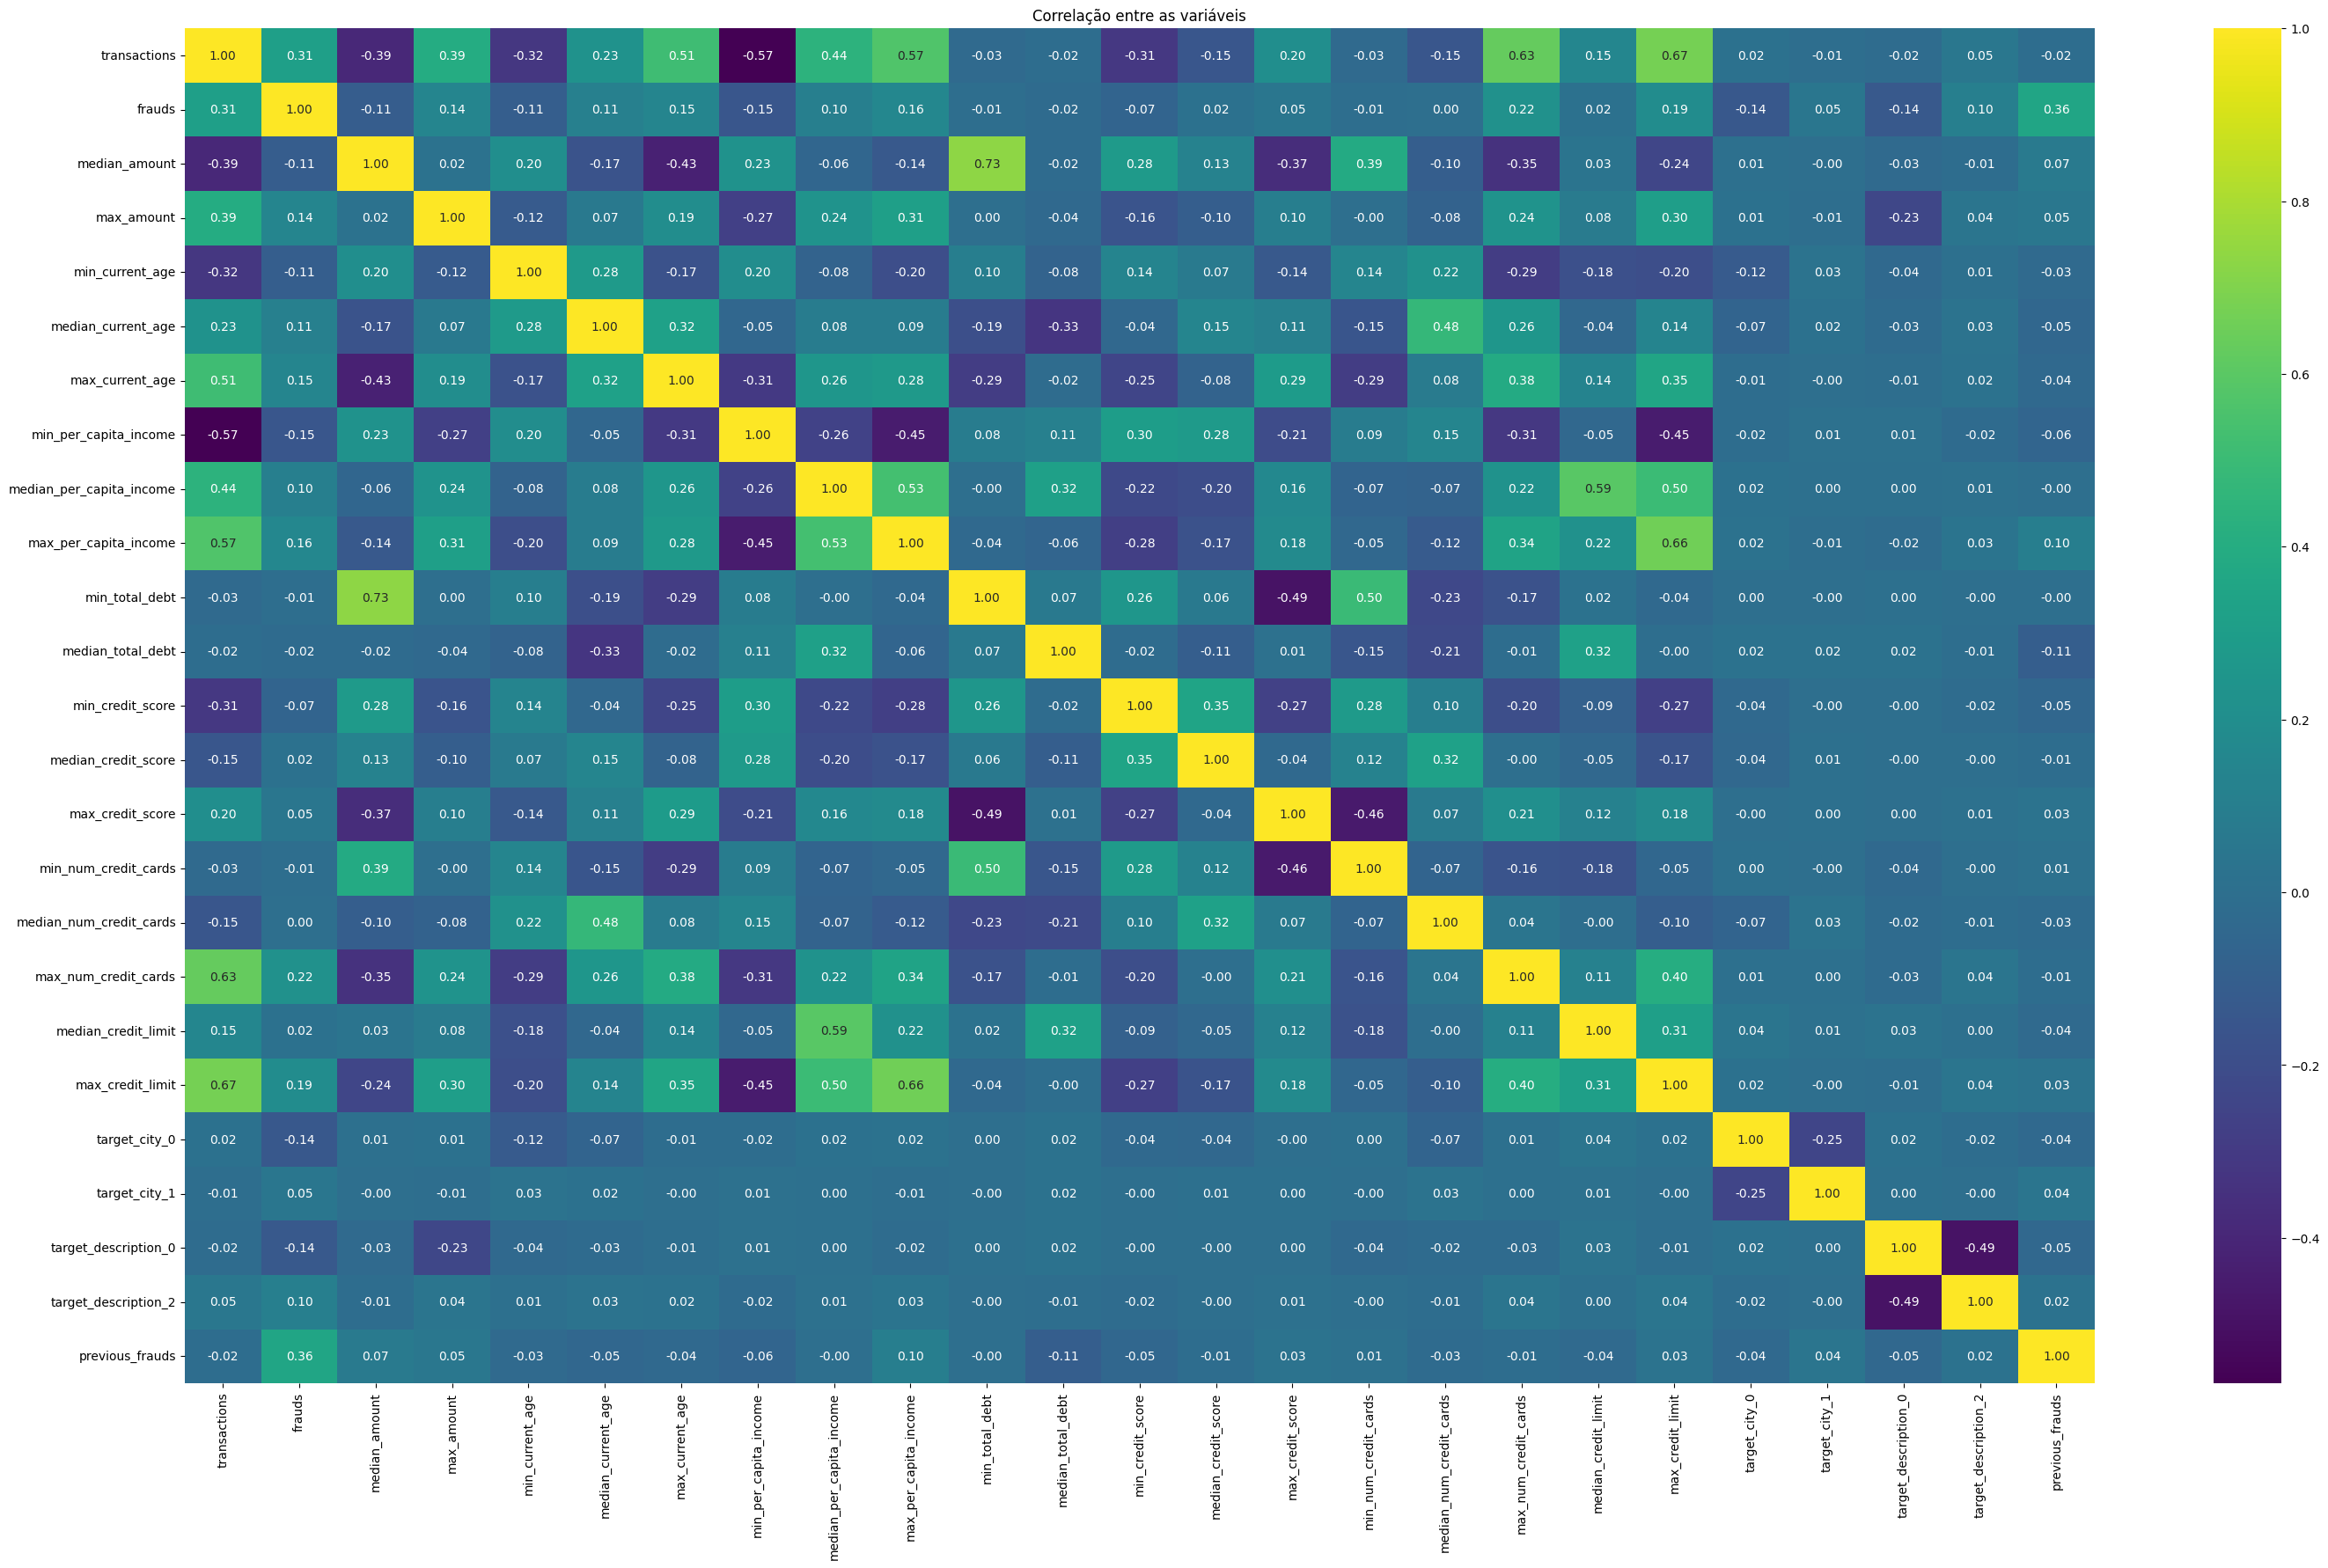

In [33]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()

plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

In [34]:
def remove_highly_correlated_features(df, threshold=0.75):
    corr_matrix = df.corr()
    upper_triangle = np.triu(np.abs(corr_matrix), k=1)

    high_corr_pairs = np.where(upper_triangle > threshold)
    columns_to_remove = set()

    for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
        col_i = corr_matrix.columns[i]
        col_j = corr_matrix.columns[j]

        if col_i not in columns_to_remove and col_j not in columns_to_remove:
            var_i = df[col_i].var()
            var_j = df[col_j].var()

            if var_i < var_j:
                columns_to_remove.add(col_i)
            else:
                columns_to_remove.add(col_j)

    return list(columns_to_remove)

In [35]:
colunas_filtradas = remove_highly_correlated_features(df_model.to_pandas().drop(columns=['date_window', 'transactions']))
colunas_filtradas

[]

In [36]:
df_model = df_model.drop(colunas_filtradas)

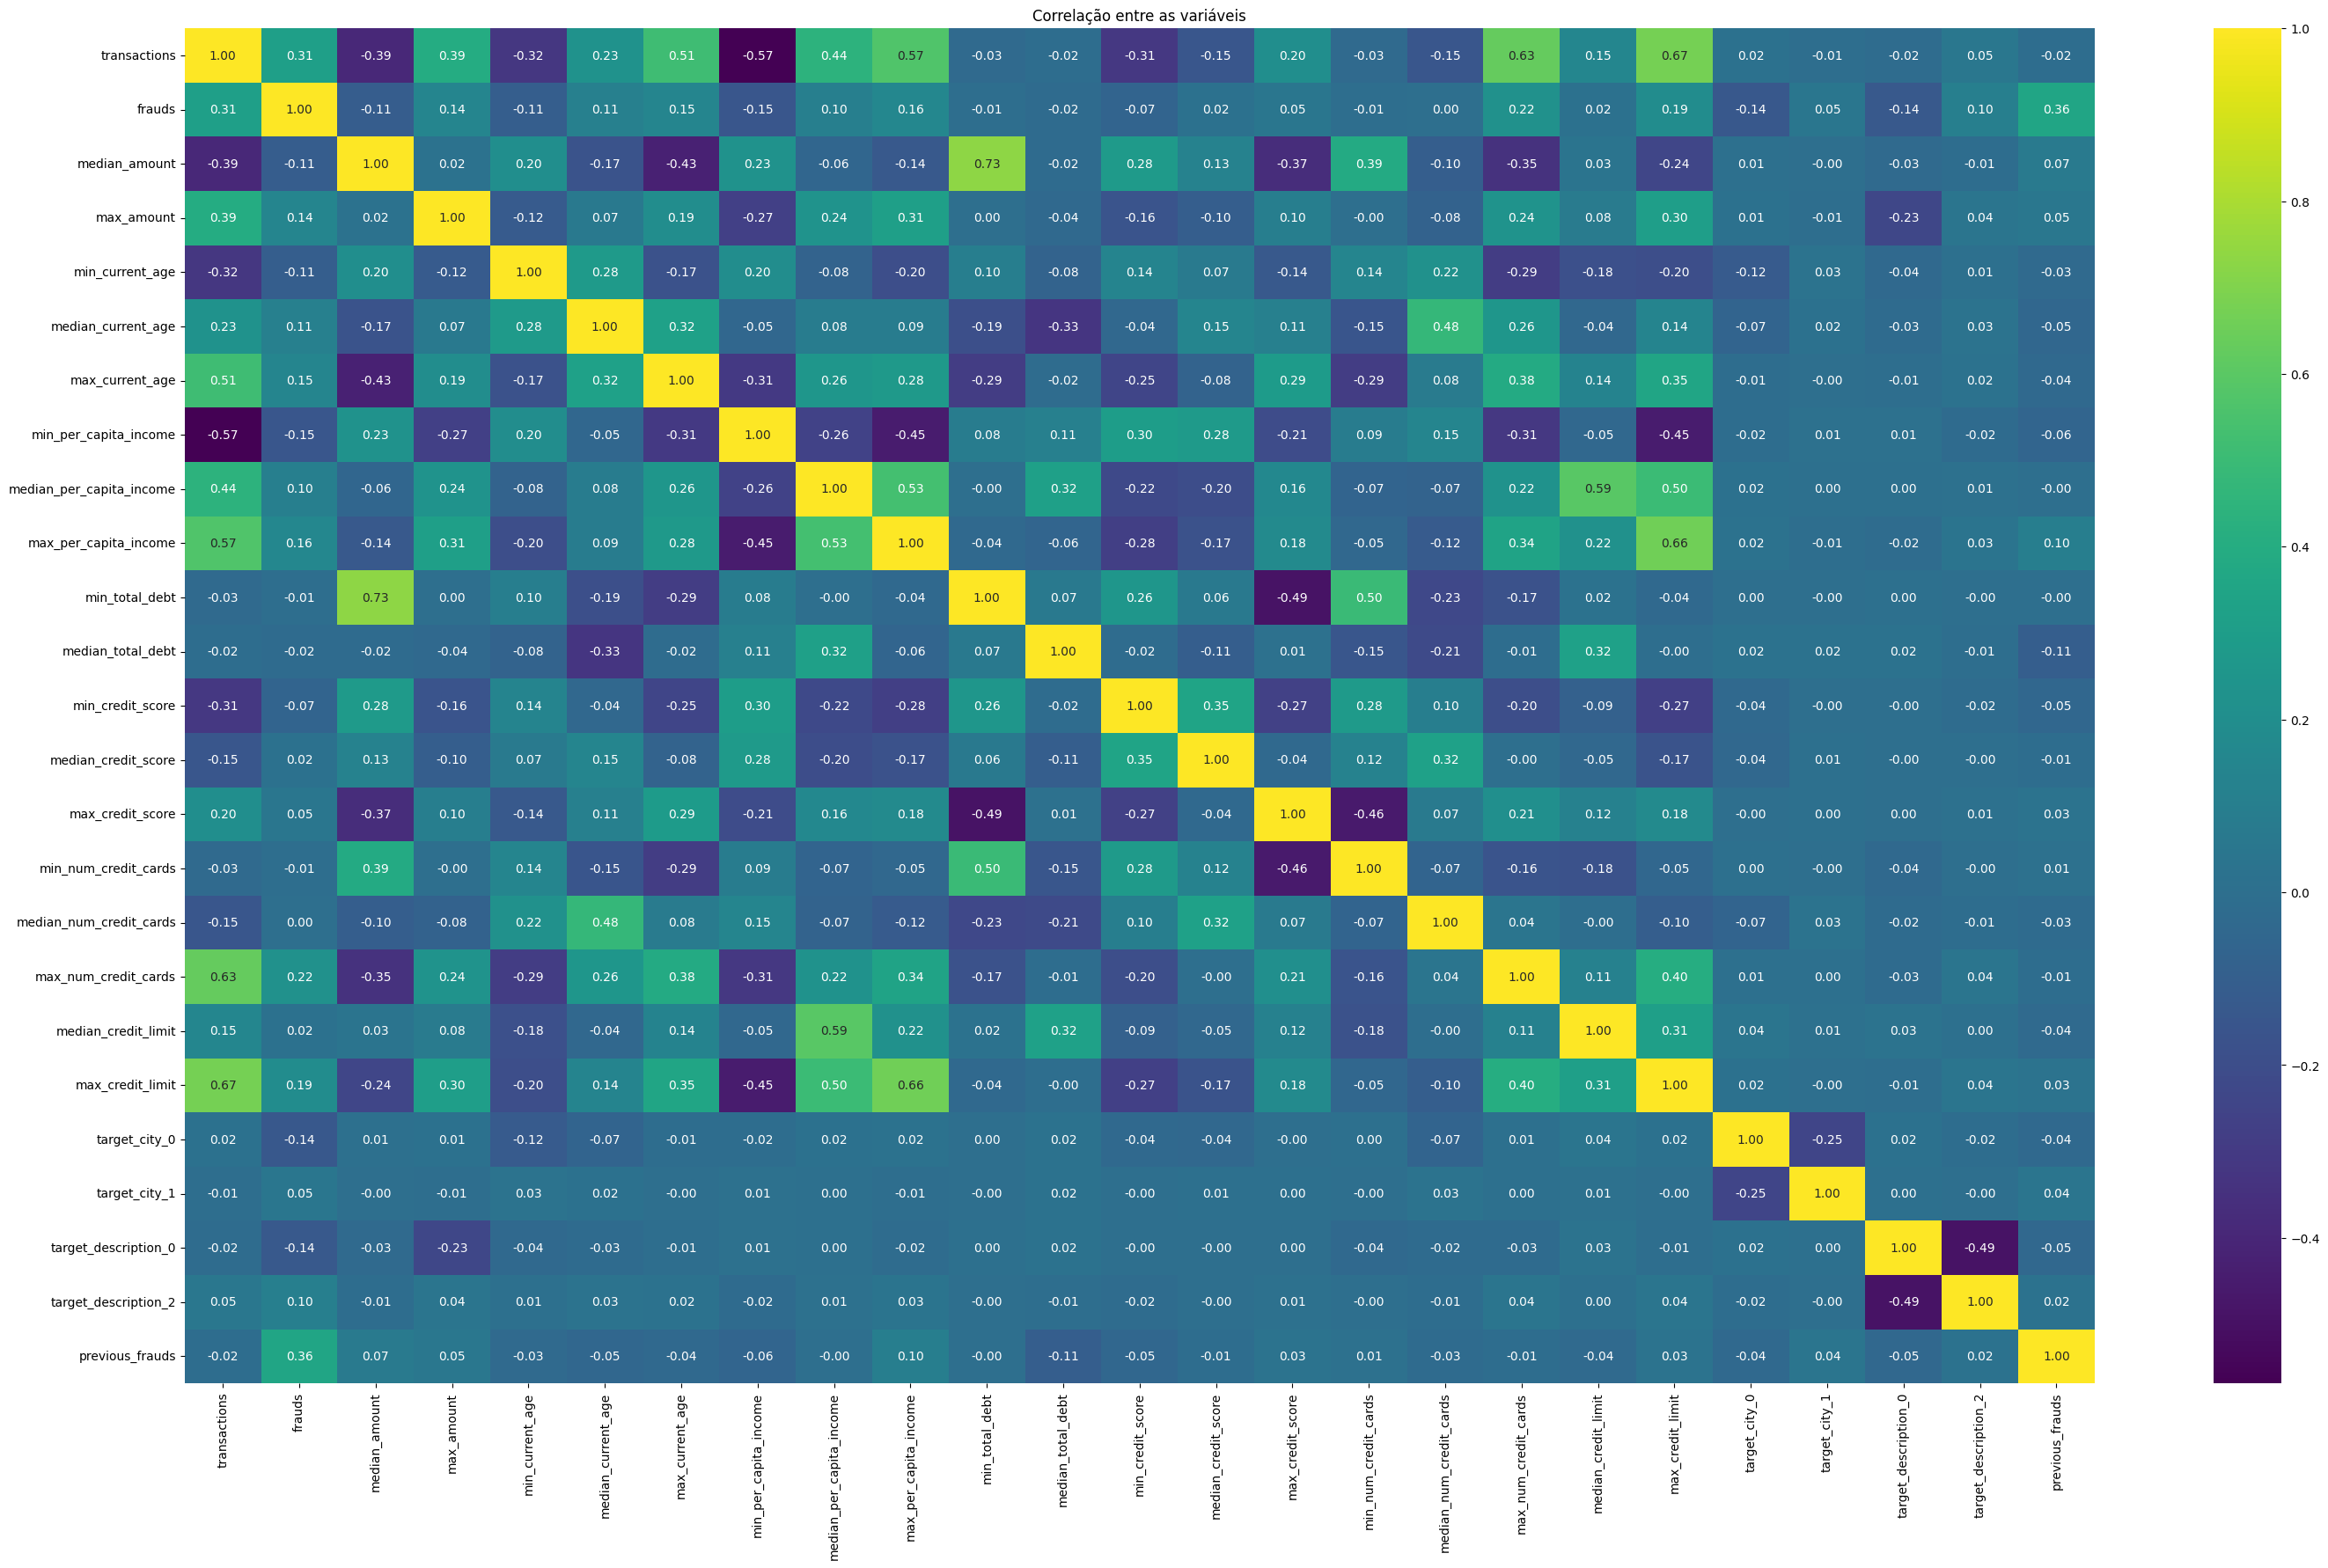

In [37]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

## Persistência do novo dataset

In [38]:
df_model.columns = [str(column).replace('-', '_').replace('&_', '').replace('__', '').replace('___', '').replace(',', '').replace('(', '').replace(')', '').replace('\'', '') for column in df_model.columns]

In [39]:
df_model.write_parquet('./datasets/transactions_features.parquet', use_pyarrow=True)

In [40]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  shutil.copy('./datasets/transactions_features.parquet', '/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
df_model.shape

(14363, 26)

In [42]:
df_model.describe()

statistic,date_window,transactions,frauds,median_amount,max_amount,min_current_age,median_current_age,max_current_age,min_per_capita_income,median_per_capita_income,max_per_capita_income,min_total_debt,median_total_debt,min_credit_score,median_credit_score,max_credit_score,min_num_credit_cards,median_num_credit_cards,max_num_credit_cards,median_credit_limit,max_credit_limit,target_city_0,target_city_1,target_description_0,target_description_2,previous_frauds
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""14363""",14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0,14363.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2014-12-01 10:40:50.797187""",5.898617,0.894103,0.054108,0.866673,25.68022,53.933532,98.307596,1.711871,23.78235,118.297238,0.017645,57.825287,4.951486,7.144627,8.494954,1.000766,3.85602,8.501845,15.473542,101.98088,0.99996,0.000004,0.999948,0.000019,0.233726
"""std""",null,3.329053,2.285803,0.016098,0.430993,1.984802,1.100665,3.179176,3.752219,0.697543,39.237448,0.993831,2.851801,0.149014,0.04068,0.035339,0.038231,0.093005,0.520349,0.667395,33.732296,0.000504,0.000126,0.000383,0.000188,0.423214
"""min""","""2010-01-01 00:00:00""",0.01,0.0,0.030616,0.10213,23.0,26.0,26.0,0.0,9.71,9.71,0.0,0.686,4.88,6.82,6.82,1.0,2.0,2.0,0.974,0.974,0.971963,0.0,0.990741,0.0,0.0
"""25%""","""2012-06-17 00:00:00""",1.77,0.0,0.04841,0.52393,24.0,53.290076,98.0,0.0,23.440535,94.302,0.0,56.02256,4.89,7.119318,8.5,1.0,3.803828,8.0,15.110939,70.187,1.0,0.0,1.0,0.0,0.0
"""50%""","""2014-12-01 12:00:00""",5.66,0.0,0.054424,0.81813,25.0,53.992647,99.0,0.0,23.869233,137.428,0.0,57.796768,4.91,7.142803,8.5,1.0,3.850178,9.0,15.491194,98.1,1.0,0.0,1.0,0.0,0.0
"""75%""","""2017-05-17 06:00:00""",8.95,0.0,0.059522,1.09448,27.0,54.612591,101.0,0.0,24.226301,163.145,0.0,59.5372,4.91,7.166538,8.5,1.0,3.9,9.0,15.855859,137.669,1.0,0.0,1.0,0.0,0.0
"""max""","""2019-10-31 18:00:00""",11.22,35.0,1.15331,6.61344,55.0,68.666667,101.0,30.307,37.597,163.145,80.367,102.569,7.88,7.88,8.5,4.0,5.222222,9.0,29.927,141.391,1.0,0.008696,1.0,0.007299,1.0
